# Prepration

## Import packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Prophet import
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [3]:
# ARIMA import
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from scipy import fft

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
# LSTM import
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/home/energiya/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py:936: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
/home/energiya/.local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [5]:
# Bidirectional LSTM import
from keras.layers.wrappers import Bidirectional
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.constraints import maxnorm

## Define required functions

In [6]:
# Time series stationary test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(14).mean()
    rolstd = timeseries.rolling(14).mean()

    #Plot rolling statistics:
    plt.figure(figsize=(10, 7))
    orig = plt.plot(timeseries,'.', color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
# convert an array of values into a dataset matrix used in LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read data

In [9]:
geoloc_dict_csv = "incident_zipcode_newzone.csv"
dtypes = {
    'Master_Incident_Number': 'str',
    'Zipcode': 'str',
    'New_Zone': 'int',
    'Mission_Type': 'int',
    'Response_Date': 'str'
}
parse_dates = ['Response_Date']
data_zones = pd.read_csv(geoloc_dict_csv, dtype=dtypes, parse_dates=parse_dates)
data_zones['Response_Date_Day'] = data_zones['Response_Date'].dt.date

In [10]:
dispatch_33 = data_zones[(data_zones['New_Zone'] == 2) & (data_zones['Mission_Type'] == 2)]
dispatch_33 = dispatch_33.groupby(['Response_Date_Day']).count()['Master_Incident_Number']

Text(0.5,1,'Zone 2, Transported')

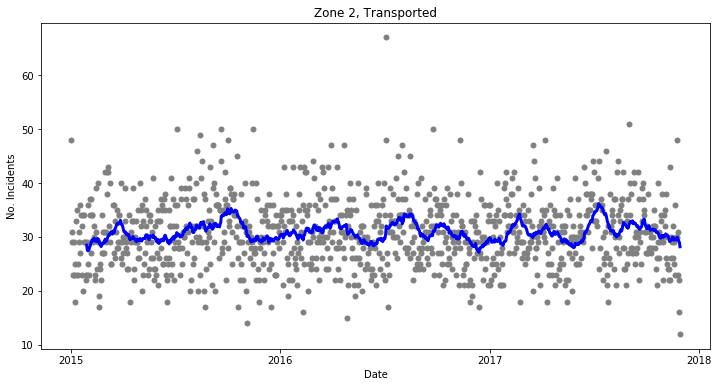

In [11]:
dispatch_33_rolling = dispatch_33.rolling(window=28).mean()
plt.figure(figsize=(12, 6))
plt.plot(dispatch_33,'.', color='grey',markersize=10, linewidth=1.5)
plt.plot(dispatch_33_rolling, color='blue', linewidth=3.0)
plt.xticks([pd.to_datetime('2015-01-01'), pd.to_datetime('2016-01-01'), pd.to_datetime('2017-01-01'), pd.to_datetime('2018-01-01')])
plt.xlabel('Date')
plt.ylabel('No. Incidents')
plt.title('Zone 2, Transported')

In [12]:
len(dispatch_33)

1064

# Prophet analysis

In [13]:
df_dispatch_33 = pd.DataFrame(dispatch_33.index)
df_dispatch_33['y'] = dispatch_33.values
df_dispatch_33.columns = ['ds', 'y']

m13 = Prophet(daily_seasonality=False)
m13.fit(df_dispatch_33)
future = m13.make_future_dataframe(periods=365)
forecast = m13.predict(future)

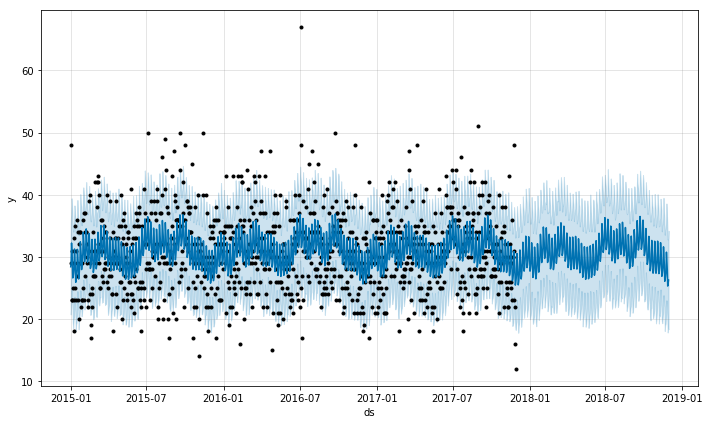

In [14]:
fig = m13.plot(forecast)

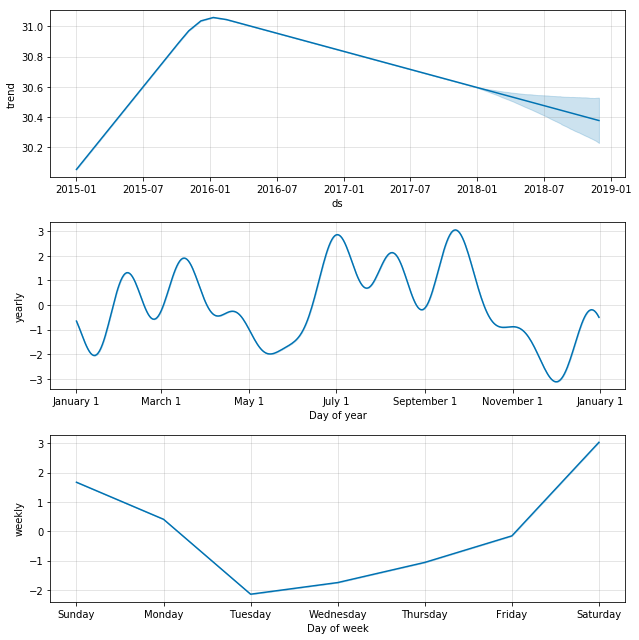

In [15]:
fig = m13.plot_components(forecast)

In [16]:
df_cv = cross_validation(m13, initial='851 days', period='1 days', horizon = '212 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet.diagnostics:Making 1 forecasts with cutoffs between 2017-05-01 00:00:00 and 2017-05-01 00:00:00


,horizon,mse,rmse,mae,mape,coverage
20,21 days,21.995339,4.689919,3.810812,0.151483,0.857143
21,22 days,20.751256,4.555355,3.672197,0.143432,0.857143
22,23 days,21.797838,4.668815,3.752102,0.153025,0.857143
23,24 days,21.356110,4.621267,3.665023,0.149423,0.857143
24,25 days,20.937362,4.575736,3.576977,0.145682,0.857143


# ARIMA analysis

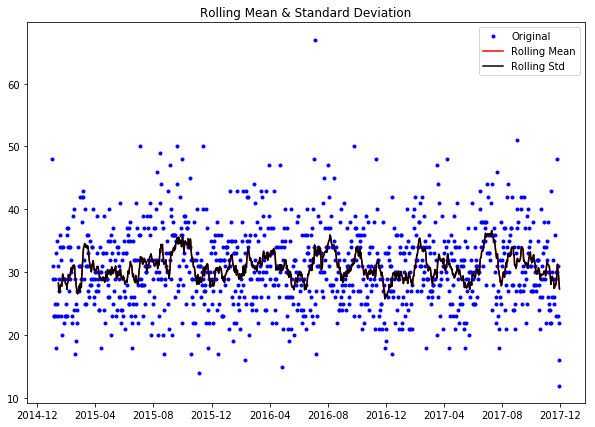

Results of Dickey-Fuller Test:
Test Statistic                   -5.225380
p-value                           0.000008
#Lags Used                       20.000000
Number of Observations Used    1043.000000
Critical Value (1%)              -3.436635
Critical Value (5%)              -2.864315
Critical Value (10%)             -2.568248
dtype: float64


In [17]:
test_stationarity(dispatch_33)

Text(0.5,1,'Residual')

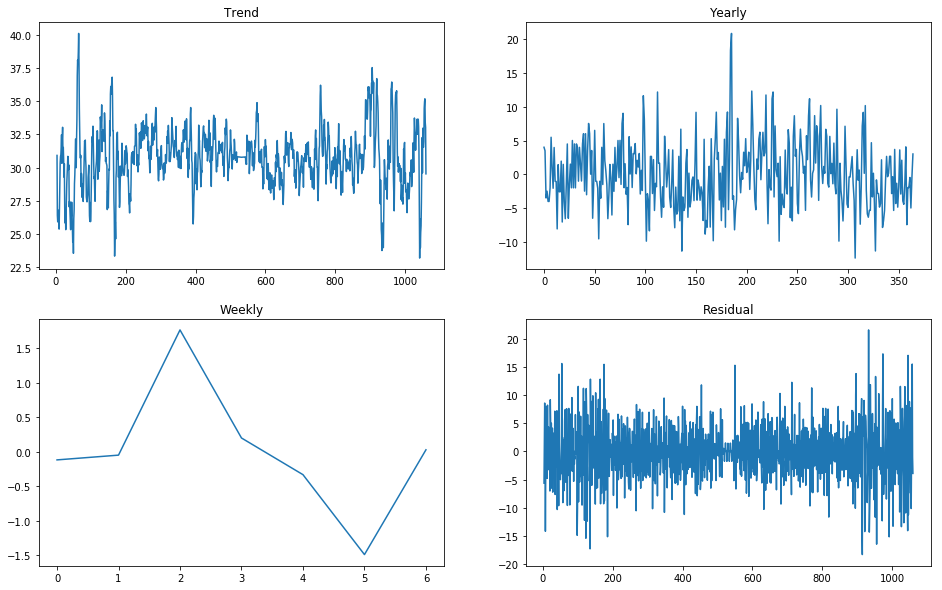

In [18]:
yearly_components = seasonal_decompose(dispatch_33.values, freq=365)
adjusted = dispatch_33 - yearly_components.seasonal
decomposition = seasonal_decompose(adjusted.values, freq=7)

fig = plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(2, 2, 2)
plt.plot(yearly_components.seasonal[:365])
plt.title('Yearly')
plt.subplot(2, 2, 3)
plt.plot(decomposition.seasonal[:7])
plt.title('Weekly')
plt.subplot(2, 2, 4)
plt.plot(decomposition.resid)
plt.title('Residual')

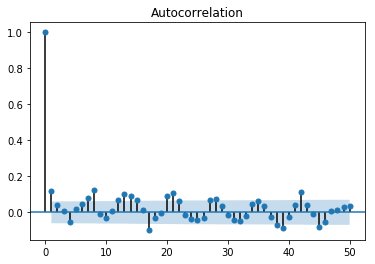

In [19]:
fig = plot_acf(dispatch_33, lags=50)

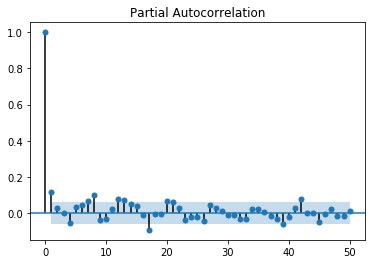

In [20]:
fig = plot_pacf(dispatch_33, lags=50)

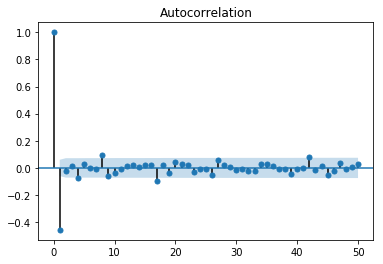

In [21]:
dispatch_33_diff = dispatch_33 - dispatch_33.shift()
fig = plot_acf(dispatch_33_diff[1:], lags=50)

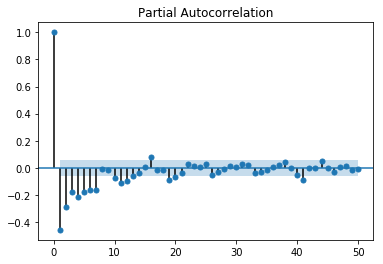

In [22]:
fig = plot_pacf(dispatch_33_diff[1:], lags=50)

In [43]:
mod = SARIMAX(dispatch_33,order=(7, 1, 7), #seasonal_order=(4, 1, 4, 4),
                                enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     Master_Incident_Number   No. Observations:                 1064
Model:                   SARIMAX(7, 1, 7)   Log Likelihood               -3403.006
Date:                    Sun, 07 Oct 2018   AIC                           6836.012
Time:                            11:12:54   BIC                           6910.559
Sample:                        01-01-2015   HQIC                          6864.260
                             - 11-29-2017                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4134      0.237     -1.744      0.081      -0.878       0.051
ar.L2         -1.0175      0.118     -8.641      0.000      -1.248      -0.787
ar.L3         -0.619

/home/energiya/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


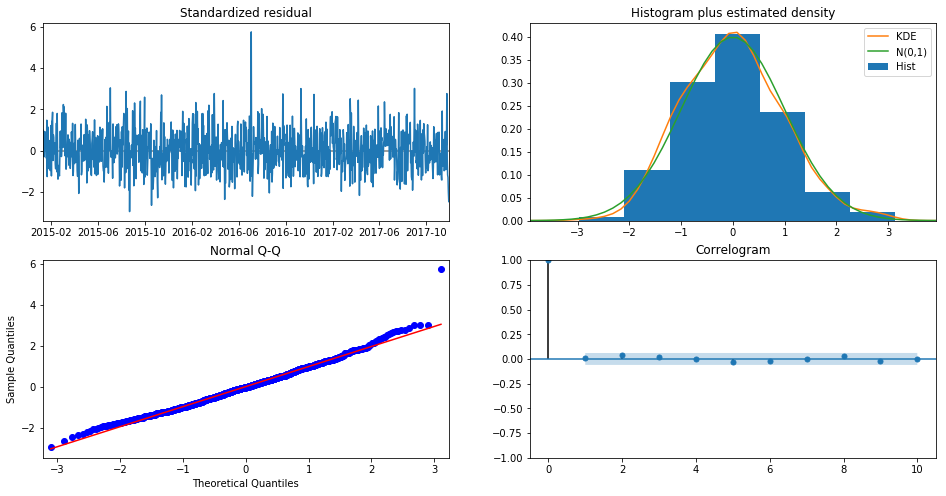

In [44]:
fig = results.plot_diagnostics(figsize=(16, 8))

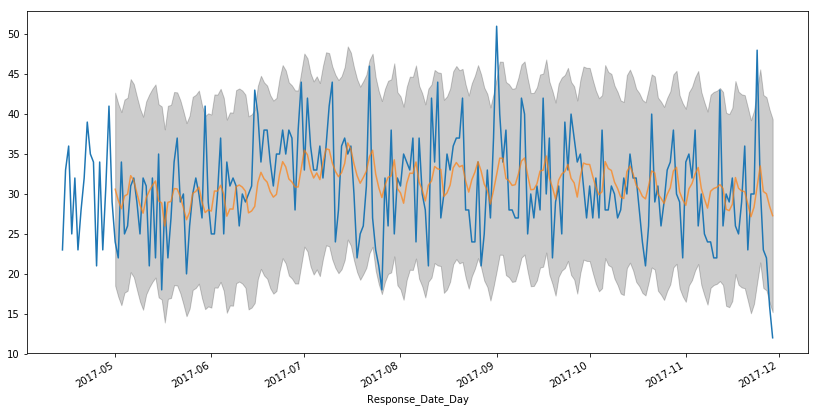

In [45]:
pred = results.get_prediction(start=pd.to_datetime('2017-05-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dispatch_33[-230:].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

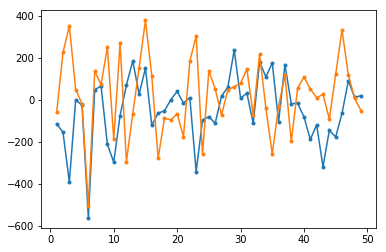

In [26]:
fft_hrs = np.fft.rfft(dispatch_33)
plt.plot(np.arange(1,50), fft_hrs.real[1:50],'.-')
plt.plot(np.arange(1,50), fft_hrs.imag[1:50],'.-')

# LSTM analysis

In [27]:
dataset = dispatch_33.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

# split into train and test sets
train_size = len(dataset) - 212 #int(len(dataset) * 0.67)
test_size = 212 #len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

852 212


In [28]:
# reshape into X=t and Y=t+1
look_back = 28
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
#model.add(LSTM(64, input_shape=(1, look_back)))
model.add(LSTM(32, batch_input_shape=(batch_size, 1, look_back), stateful=True, return_sequences=True))
model.add(LSTM(32, batch_input_shape=(batch_size, 1, look_back), stateful=True, return_sequences=True))
model.add(LSTM(32, batch_input_shape=(batch_size, 1, look_back), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)
#for i in range(100):
#    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
#    model.reset_states()

Epoch 1/100
823/823 [==============================] - 3s 3ms/step - loss: 0.0174
Epoch 2/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0144
Epoch 3/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0143
Epoch 4/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 5/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0140
Epoch 6/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 7/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 8/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 9/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0135
Epoch 10/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 11/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0138
Epoch 12/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0139
Epoch 13/100


823/823 [==============================] - 2s 2ms/step - loss: 0.0125
Epoch 100/100
823/823 [==============================] - 2s 2ms/step - loss: 0.0124


In [30]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 6.03 RMSE
Test Score: 6.14 RMSE


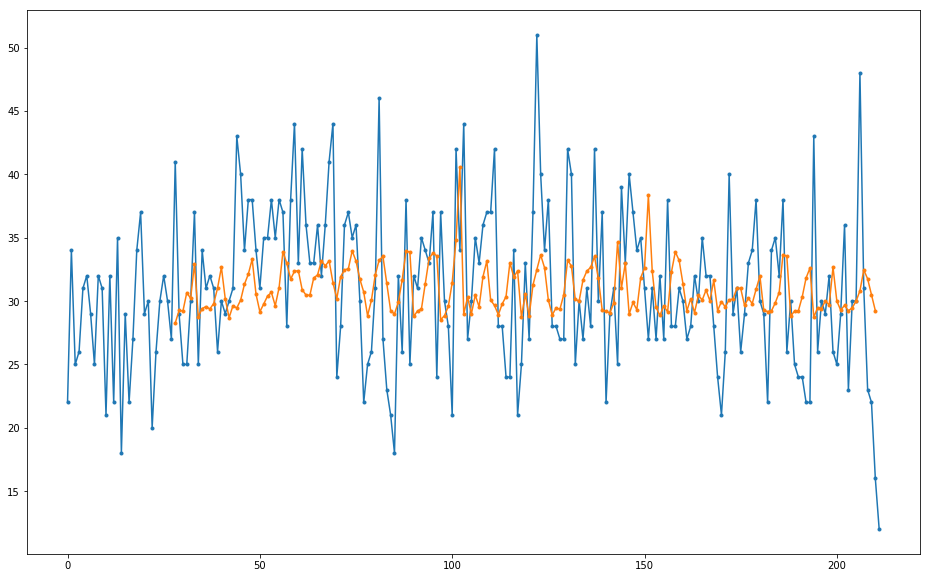

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(16, 10))
plt.plot(scaler.inverse_transform(dataset)[-212:],'.-')
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot[-212:],'.-')

# Comparison

Text(0.5,1,'Zone 2, Transported')

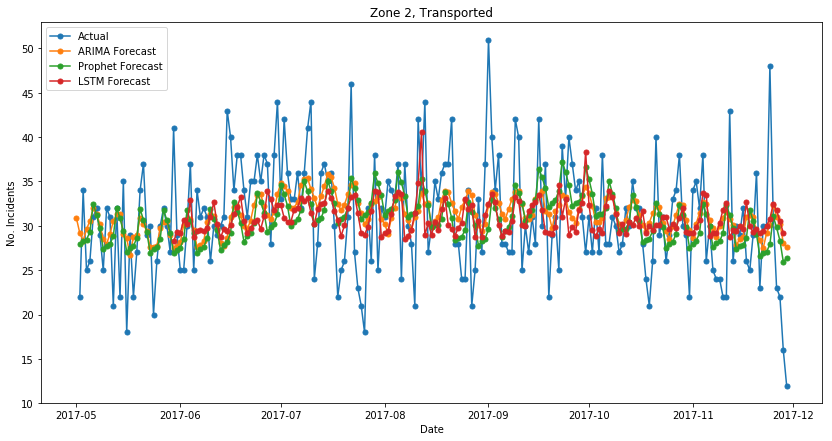

In [32]:
#font = {'family' : 'sans',
#        'weight' : 'normal',
#        'size'   : 24}
#plt.rc('font', **font)

plt.figure(figsize=(14, 7))
plt.plot(dispatch_33[-212:],'.-', markersize=10, linewidth=1.5, label = 'Actual')
plt.plot(pred.predicted_mean,'.-', markersize=10, linewidth=1.5, label = 'ARIMA Forecast')
plt.plot(df_cv['ds'],df_cv['yhat'],'.-', markersize=10, linewidth=1.5, label = 'Prophet Forecast')
plt.plot(df_cv['ds'],testPredictPlot[-212:],'.-', markersize=10, linewidth=1.5, label = 'LSTM Forecast')
plt.legend()
plt.xlabel('Date')
plt.ylabel('No. Incidents')
plt.title('Zone 2, Transported')

In [33]:
print('Prophet MAPE:', mean_absolute_percentage_error(dispatch_33.values[-213:-1],df_cv['yhat'].values),'%')

Prophet MAPE: 16.014600258074626 %


In [46]:
print('ARIMA MAPE:', mean_absolute_percentage_error(dispatch_33[-213:],pred.predicted_mean.values),'%')

ARIMA MAPE: 16.401003274683895 %


In [35]:
print('LSTM MAPE:', mean_absolute_percentage_error(dispatch_33.values[-184:-1],testPredictPlot[-184:-1].reshape(1,-1)[0]),'%')

LSTM MAPE: 15.988611875462208 %
